# Рабочий ноутбук для решения задачи предсказания территории на которой находится торговая точка

## Глоссарий
**Торговая точка** - индивидуальный предприниматель или организация осуществляющая продажу продукции Компапании конечному потребителю в оборудованном помещении по конкретному адресу.

**Дистрибьютор** - клиент Компании осуществляющий продажу товаров в торговые точки определенной географической территории. Дистрибьютор имеет по крайней мере один филиал и один офис.

**Код доставки** - код адреса доставки из КИС Компании. Соответствует физическому складу. Обычно, один филиал имеет один адрес доставки, но может иметь и больше. В решаемой задаче код доставки - это целевой класс (поле SHIP_TO_RSS).

## Входные данные
Данные поступают из двух файлов, которые формируются в существующей системой отчетности. В процессе обработки файлы могут быть объединены по полю “Код торговой точки”.
#### Файл Coordinates.xlsx
Файл содержит координаты торговых точек. Не все торговые точки имеют координаты. В процессе подготовки данных для обучения модели, точкам без координат будут назначены усредненные координаты соседних точек, которые находятся в том-же населенном пункте, что и точка без координат.
#### Файл Report Territory Management.xlsx
Данный файл является специальным отчетом, который требуется для работы оператора процесса, а также является входным файлом для последующего расчета. Файл содержит следующую информацию по точкам:
- Иерархия дистрибьюторов (Регион - Дистрибьютор - Филиал)
- Иерархия сотрудников
- Адресный классификатор (пять уровней)
- Характеристики точки: Сеть, Тир, Сегмент, Формат и т.п.
- Информация о посещении точки
- Код филиала на территории которого находится торговая точка (этот код необходимо предсказать, если отсутствует)

## Анализ и подготовка данных

In [277]:
# Импорт библиотек
import pandas as pd
import numpy as np
import scipy
from scipy import sparse

import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import missingno as msno

# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
# from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import category_encoders as ce

from pprint import pprint
from time import time

coord_file = 'Coordinates.xlsx'
report_file = 'Report Territory Management.xlsx'

### Координаты точек

Посмотрим на файл с координатами точек. Видим, что в файле содержится 435 тысяч записей без пустых значений.

In [6]:
# Загрузка файла с кординатами в DataFrame
df_coor = pd.read_excel(coord_file)
df_coor.columns = ['SWE_Store_Key','Latitude','Longitude']
df_coor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435419 entries, 0 to 435418
Data columns (total 3 columns):
SWE_Store_Key    435419 non-null int64
Latitude         435419 non-null float64
Longitude        435419 non-null float64
dtypes: float64(2), int64(1)
memory usage: 10.0 MB


Но что с валидностью значений? Необходимо учитывать, что допустимые значения широты находятся в диапазоне от -90 до +90, а значения долготы - в диапазоне от -180 до +180. Откинем недопустимые значения. Как видим, их не много.

In [7]:
# Оставить только допустимые координаты (широта -90...+90, долгота -180..+180)
init_num = df_coor.shape[0]
df_coor = df_coor[(df_coor['Latitude']>=-90) & (df_coor['Latitude']<=90)]
df_coor = df_coor[(df_coor['Longitude']>=-180) & (df_coor['Longitude']<=180)]
print(f'Валидных значений: {df_coor.shape[0]}, некорректных значений: {init_num - df_coor.shape[0]}')

Валидных значений: 435411, некорректных значений: 8


Беря во внимание информацию из Википедии о крайних точках Российской Федерации (https://ru.wikipedia.org/wiki/%D0%9A%D1%80%D0%B0%D0%B9%D0%BD%D0%B8%D0%B5_%D1%82%D0%BE%D1%87%D0%BA%D0%B8_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8), отбросим точки из других стран (берем с запасом). Осталось 396 тысяч точек с координатами

In [8]:
# Оставить только точки, с координатами в РФ
df_coor = df_coor[(df_coor['Latitude']>40)&(df_coor['Latitude']<82)]
df_coor = df_coor[((df_coor['Longitude']>=10)&(df_coor['Longitude']<180)) | \
    ((df_coor['Longitude']>=-180)&(df_coor['Longitude']<-160))]
print(f'Всего данных по точкам  в РФ: {df_coor.shape[0]}')

Всего данных по точкам  в РФ: 396144


Посмотрим на распределение значений на графике типа Box & Whiskers. Получается медианное значение широты 55, а для долготы 50, с очевидно значительно меньшим количеством точек на крайних границах, которые не являются выбросами, в данном случае. Распределение не нормальное.

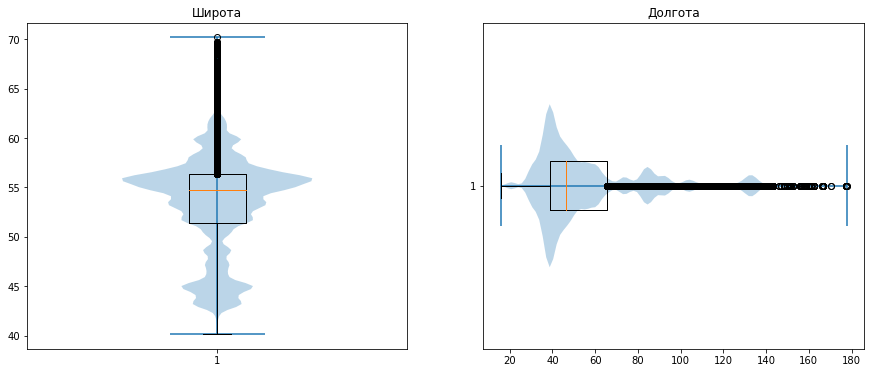

In [9]:
# Нарисовать графики типа Box & Whiskers плюс violinplot с визулальным распределением значений
fig, axes = plt.subplots(1,2, figsize=(15,6))
axes[0].violinplot(df_coor['Latitude'].values)
axes[0].boxplot(df_coor['Latitude'].values, whis=(0,1))
axes[0].set_title('Широта')
axes[1].violinplot(df_coor[df_coor['Longitude']>0]['Longitude'].values, vert=False)
axes[1].boxplot(df_coor[df_coor['Longitude']>0]['Longitude'].values, vert=False, whis=(0,1))
axes[1].set_title('Долгота')
plt.show()

In [10]:
# Детальная статистика по координатам точек
df_coor.describe()

,SWE_Store_Key,Latitude,Longitude
count,3.961440e+05,396144.000000,396144.000000
mean,1.014634e+14,53.448102,57.361018
std,1.236369e+12,5.054505,27.700726
min,1.000201e+09,40.166158,-179.118938
25%,1.000500e+14,51.364246,38.684879
50%,1.012700e+14,54.751350,46.110459
75%,1.027100e+14,56.305230,65.566879
max,1.044500e+14,70.167074,177.691300


### Информация по торговым точкам

Теперь перейдем к рассмотрению файла с основной информацией по торговым точкам. Как видно, информация по точке, полученная из справочников с основными мастер-данными, кажется полной (иерархия дистрибьюторов, иерархия сотрудников, информация по сети и точке, а также адресный классификатор), то есть признаки не содержат пропущенных значений.

In [11]:
# Загрузка файла с территориями точек в DataFrame и переименование столбцов для удобной работы
df_terr = pd.read_excel(report_file, skiprows=1)
df_terr.columns = ['Region','Distrib','Office','FFDSL','TSE_MTDE','Level_Torg_Region1','Level_Torg_Region2',
    'Filial_Name','Filial_Ship_To','Chain_Type','Chain_Name','Chain_Id','Chain_Chain_Tier_MWC',
    'Chain_Chain_Sub_Tier_MWC','SWE_Store_Key','Store_Status','Outlet_Name','Channel_Name_2018',
    'Outlet_Type_2018','Trade_Structure','From_Dc','Segment_MWC_Segment_Name','Cluster_MWC',
    'Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5','LSV_WWY','LSV_CHOCO',
    'LSV_MWC','Covering_Outlet_id','General_Duplicate','Ship_To_Visited','Filial_Visited',
    'Ship_to_Name_TO_BE','Region_loaded_RSS','Ship_to_TO_BE_Name_loaded_RSS','SHIP_TO_RSS',
    'Ship_to_Code_TO_BE','DC','Changed','Change_Period']

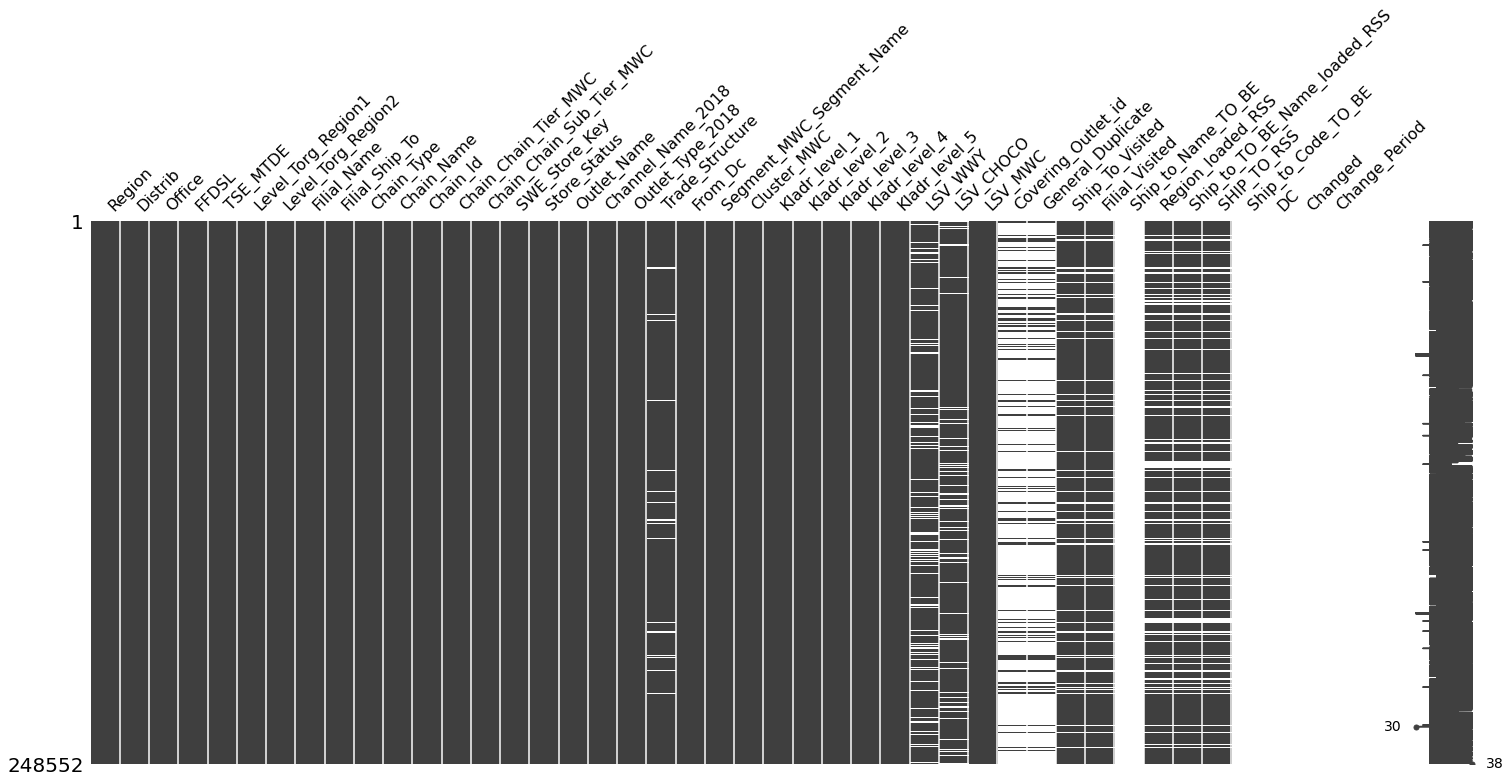

In [12]:
msno.matrix(df_terr)

Удалим поля с названиями, для которых имеются соответствующие коды, а также поля без значений. Также нужно убрать информацию об объеме продаж. Оставляем признак Ship_To_Visited с информацией о том, какой дистрибьютор сделал последний визит в точку (нам известно, что точку могут посещать несколько дистрибьюторов). Дальше нужно с ним внимательно поработать.

In [13]:
df_terr = df_terr[['SWE_Store_Key','Region','Distrib','Office','FFDSL','TSE_MTDE','Level_Torg_Region1',
    'Level_Torg_Region2','Filial_Name','Filial_Ship_To','Chain_Type','Chain_Id','Chain_Chain_Tier_MWC',
    'Chain_Chain_Sub_Tier_MWC','Channel_Name_2018','Outlet_Type_2018','Trade_Structure','From_Dc',
    'Segment_MWC_Segment_Name','Cluster_MWC','Covering_Outlet_id','General_Duplicate','Ship_To_Visited',
    'SHIP_TO_RSS','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5']]

Также от бизнеса получена информация, что в данных содержится информация о точках-дубликатах и определен способ оставить только основные (актуальные) точки

In [14]:
df_terr = df_terr[df_terr['General_Duplicate']!='Дубликат']
df_terr.drop(['Covering_Outlet_id','General_Duplicate'], axis=1, inplace=True)

Объединим отчет по территориям с координатами.

In [15]:
df = pd.merge(df_terr, df_coor, on='SWE_Store_Key', how='left')
# del df_terr
# del df_coor

Поскольку для каждой точки известен адрес, можно воспользоваться этой информацией, чтобы приблизительно восстановить координаты для точек с отсутствующими координатами. Для этого с бизнесом согласован алгоритм, при котором точкам без координат будут назначены усредненные координаты соседних точек, которые находятся в том-же населенном пункте, что и точка без координат. В случае отсутствия соседей в населенном пункте будет использоваться более высокий уровень адресного классификатора. После этого можно избавиться от адресного классификатора.

In [16]:
%%time
df['Latitude'].replace(0, np.NaN, inplace=True)
df['Longitude'].replace(0, np.NaN, inplace=True)
df['isCoord'] = ~( (df['Latitude'].isna()) | (df['Longitude'].isna()) )

kladr_lat_grouped = df[df['isCoord']==1].groupby(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']).Latitude.mean()
kladr_lon_grouped = df[df['isCoord']==1].groupby(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']).Longitude.mean()


def get_avg_coordinate(row, kladr_grouped):
    """
    Вернуть среднюю координату населенного пункта, области, региона или страны. Используем функции
    multiindex.isin().any(), чтобы проверить, что в Series имеется индекс для всех 4-х уровней
    и вернуть значение. В случае отсутствия индекса, отрубить последний уровень в индексе и проверить
    индекс для 3-х уровней и т.д.

    Parameters:
    row (Series): ['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'] для которых нужно
        получить координату
    kladr_grouped (Series): с мультииндексом (['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4'])
        который содержит значения координаты для 4-х уровней из адресного классификатора
        
    Returns:
    float: Координата

    """
    try:
        if kladr_grouped.index \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4']]
        elif kladr_grouped.index.droplevel(['Kladr_level_4']) \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3']].mean()
        elif kladr_grouped.index.droplevel(['Kladr_level_3','Kladr_level_4']) \
                .isin([(row['Kladr_level_1'],row['Kladr_level_2'])]).any():
            return kladr_grouped[row['Kladr_level_1'],row['Kladr_level_2']].mean()
        elif kladr_grouped.index.droplevel(['Kladr_level_2','Kladr_level_3','Kladr_level_4']) \
                .isin([(row['Kladr_level_1'])]).any():
            return kladr_grouped[row['Kladr_level_1']].mean()
        else:
            return 0
    except:
        print(row['Kladr_level_1'],row['Kladr_level_2'],row['Kladr_level_3'],row['Kladr_level_4'])
        raise KeyError


df.loc[df['isCoord']==0,'Latitude'] = \
    df.loc[df['isCoord']==0][['SWE_Store_Key','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']].apply( \
        get_avg_coordinate, args=(kladr_lat_grouped,), axis=1)

df.loc[df['isCoord']==0,'Longitude'] = \
    df.loc[df['isCoord']==0][['SWE_Store_Key','Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4']].apply( \
        get_avg_coordinate, args=(kladr_lon_grouped,), axis=1)

Wall time: 4min


In [17]:
df.drop(['Kladr_level_1','Kladr_level_2','Kladr_level_3','Kladr_level_4','Kladr_level_5'], axis=1, inplace=True)
df['isTrain'] = ~ df['SHIP_TO_RSS'].isna()

In [18]:
df_init = df.copy()

### Анализ целевой переменной SHIP_TO_RSS

Поскольку целевой признак SHIP_TO_RSS это не непрерывная величина, а возможные фиксированные значения, то наша задача сводится к задаче мультиклассовой классификации. Нужно обучить модель показывать наиболее вероятный код SHIP_TO_RSS по входным признакам. Доля точек с неизвестным целевым признаком - примерно 10%.

In [19]:
# Посчитать длину поля SHIP_TO_RSS, сгруппировать по длине и вывести первое значение из каждой группы
ship = df[['SHIP_TO_RSS']]
ship.loc[~ship['SHIP_TO_RSS'].isna(),'Length'] = \
    ship.loc[~ship['SHIP_TO_RSS'].isna()].SHIP_TO_RSS.apply(lambda x: len(str(x).strip()))
ship.groupby('Length').SHIP_TO_RSS.first()

Length
8.0                            10340352
19.0                10342443 , 10430024
30.0     10262975 , 10428588 , 10432783
Name: SHIP_TO_RSS, dtype: object

Задан дополнительный вопрос к бизнесу, почему для некоторых точек идёт два или три кода доставки, и получен ответ, что нужно использовать только первый код.

In [20]:
# SHIP_TO_RSS взять первые 8 символов и преобразовать к типу str
df.loc[~df['SHIP_TO_RSS'].isna(),'SHIP_TO_RSS'] = \
    df.loc[~df['SHIP_TO_RSS'].isna()]['SHIP_TO_RSS'].apply(lambda x: str(x).strip()[:8])

Построим гистограмму распределения количества кодов доставки по частоте количества точек на территории. Видно, что  выборка данных не является сбалансированной.

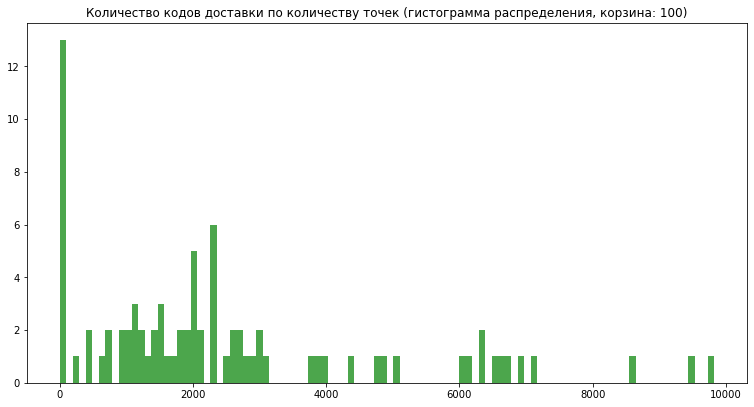

In [21]:
# Посчитаем количество точек по классам
ship_counts = df[~df['SHIP_TO_RSS'].isna()].groupby('SHIP_TO_RSS').size().to_frame()
ship_counts.reset_index(inplace=True)
ship_counts.columns = ['SHIP_TO_RSS','Counts']

fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
bins = 100
axes.hist(x = ship_counts['Counts'].values,
        bins = bins,
        color ='green',
        alpha = 0.7)
axes.set_title(f'Количество кодов доставки по количеству точек (гистограмма распределения, корзина: {bins})')
plt.show()

Видно, что имеется 13 кодов доставки с количеством точек меньшим 100. Бизнес говорит, что у с одного адреса доставки не может грузиться так мало точек. Необходимо проверить, что модель может предсказывать класс на малом количестве точек. Согласовали подход: проанализировать точность модели при предсказывании класса с малым количеством сэмплов и, в случае, необходимости, сообщать пользователю о наличии классов с недостаточным количеством точек, но не "угадывать" класс (исключать такие классы из обучения модели).

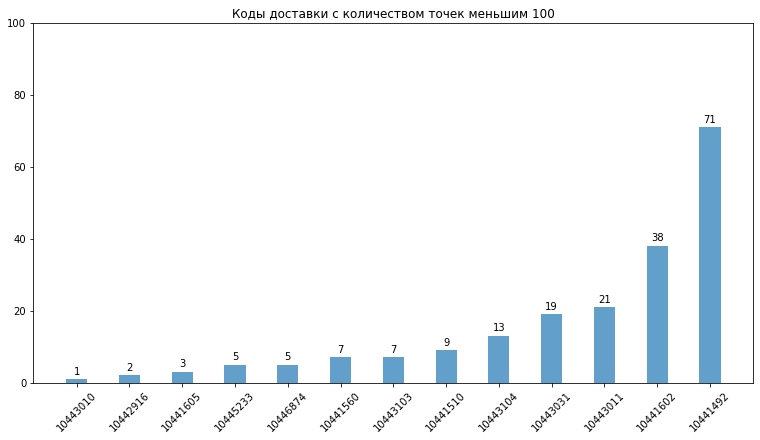

In [22]:
fig = plt.figure(figsize=(10,5))
axes = fig.add_axes([0, 0, 1, 1])
axes.set_ylim(0, 100)
threshold = 100
df_aux = ship_counts[ship_counts['Counts']<threshold].sort_values('Counts', ascending=True)
rects=axes.bar(x = df_aux['SHIP_TO_RSS'].values.astype('str'),
           height = df_aux['Counts'].values, 
           width = 0.4,
           align = 'center',
           alpha = 0.7)
for tick in axes.get_xticklabels():
    tick.set_rotation(45)
for rect in rects:
    h = rect.get_height()
    axes.annotate('%.0f' % (h),
                xy=(rect.get_x() + rect.get_width() / 2, h),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
axes.set_title(f'Коды доставки с количеством точек меньшим {threshold}')
plt.show()

В данных присутствует код Ship_To_Visited очень похожий на SHIP_TO_RSS. Действительно, смысл кода один и тот-же, но есть важное отличие: это код того филиала дистрибьютора, который __последний__ посетил торговую точку. Знаем, что одну и ту же точку могут посещать разные дистрибьюторы. Отформатируем этот признак и посмотрим совпадения с целевой переменной.

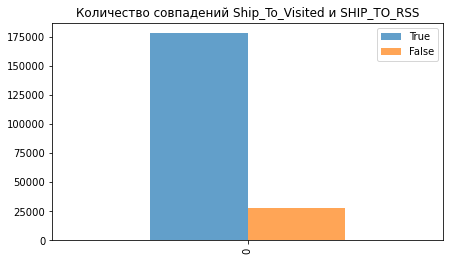

Несовпадение кодов наблюдается в 13.7% случаев


In [23]:
df.loc[~df['Ship_To_Visited'].isna(),'Ship_To_Visited'] = \
    df.loc[~df['Ship_To_Visited'].isna()]['Ship_To_Visited'].apply(lambda x: str(x).strip()[:8])

matching = df[~df['SHIP_TO_RSS'].isna()]['Ship_To_Visited']==df[~df['SHIP_TO_RSS'].isna()]['SHIP_TO_RSS']
matching.value_counts().to_frame().T.plot(kind='bar', figsize=(7,4), alpha=0.7,
                                          title='Количество совпадений Ship_To_Visited и SHIP_TO_RSS')
plt.show()
vc = matching.value_counts()
print(f'Несовпадение кодов наблюдается в {vc[False]/(vc[False]+vc[True])*100:.1f}% случаев')

### Анализ пропущенных значений

Посмотрим внимательнее на признаки, сразу замечаем присутствие значений "!ERR". Выясняем с бизнесом. Оказывается, из отчетной системы выгружаются значения !ERR если иерархия отсутствует.

In [24]:
df['Region'].value_counts()

South         44948
Volga         33893
Siberia       32200
East          25373
Ural          23755
North-West    23739
!ERR          20071
Moscow        17724
Name: Region, dtype: int64

Представим значения !ERR как NaN и посмотрим статистики по пропущенным значениям.

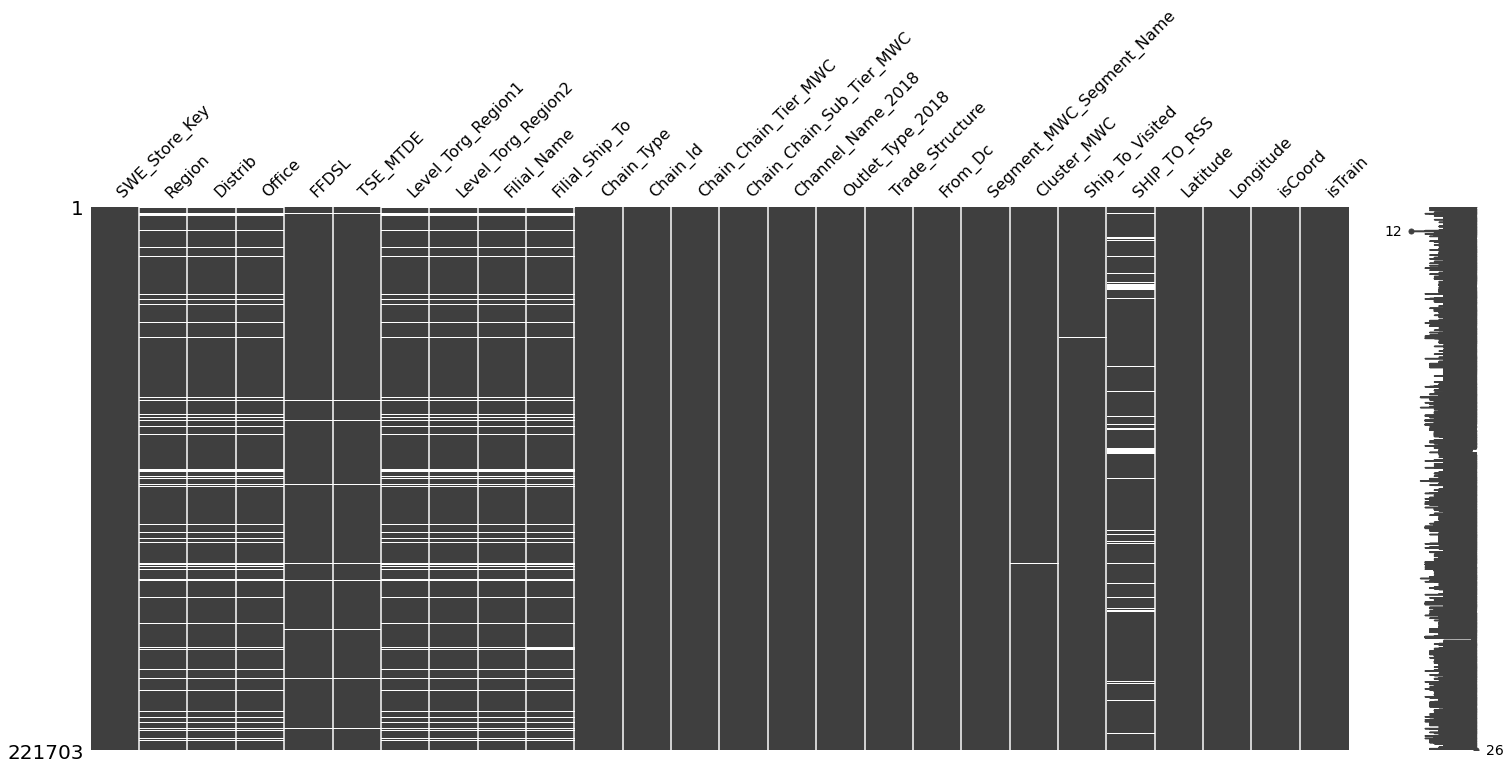

In [25]:
df.replace('!ERR', np.NaN, inplace=True)
msno.matrix(df)

Оценим пропуски количественно, для этого создадим таблицу некоторых статистик для всех признаков.

In [26]:
df_stats = pd.DataFrame(columns = ['column', 'values', 'num_unique', 'num_nan', 'pct_nan'])
tmp = pd.DataFrame()

for c in df.columns:
    tmp['column'] = [c]
    tmp['values'] = [df[c].unique()]
    tmp['num_unique'] = len(list(df[c].unique()))
    tmp['num_nan'] = df[c].isnull().sum()
    tmp['pct_nan'] = round(df[c].isnull().sum() / df.shape[0] * 100, 1)
    df_stats = df_stats.append(tmp)
    
df_stats[['column','values','num_unique','num_nan','pct_nan']]

,column,values,num_unique,num_nan,pct_nan
0,SWE_Store_Key,"[1000201031, 100050000000002, 100050000000031,...",221703,0,0.0
0,Region,"[Siberia, North-West, nan, Moscow, Ural, Volga...",8,20071,9.1
0,Distrib,"[ООО Гермес, ЗАО Денди, SF Мегаполис, nan, ООО...",62,20018,9.0
0,Office,"[MWC ООО Гермес (Новокузнецк), MWC Денди ЗАО, ...",168,20018,9.0
0,FFDSL,"[MWC FFDL Kuzbass (Vetrova Marina), MWC FFDL S...",39,4499,2.0
0,TSE_MTDE,"[MWC TSE Novokuznetsk (Sandler Kseniya), MWC T...",359,4499,2.0
0,Level_Torg_Region1,"[TL MWC: Север Кузбасса (Мокроусов Илья), TL: ...",521,20018,9.0
0,Level_Torg_Region2,[Агент МарсРигли-08 (Киселевск-2)(Погребных А....,2529,20018,9.0
0,Filial_Name,"[MWC ООО Гермес (Новокузнецк), MWC Денди ЗАО, ...",106,20019,9.0
0,Filial_Ship_To,"[10340352, 10407751, 10407053, nan, 10399270, ...",97,21163,9.5


Проверка того, как работает отчетная система отдела продаж, из которой получен отчет по точкам, показывает, что иерархия сотрудников компании (FFDSL, TSE_MTDE) задается отдельно от иерархии дистрибьюторов (куда попадают также торговые агенты Level_Torg_). Это подтверждает также совпадение количества пропущенных значений (примерно 9% для иерархии дистрибьюторов и 2% для иерархии сотрудников).

Чтобы подтвердить это предположение, построем тепловую карту корреляции пропущенных значений. По ней видно, что наличие пропущенных значений в признаках иерархии дистрибьютора (Distrib, Office, Level_Torg_Region1, Level_Torg_Region1, Filial_Name, Filial_Ship_To) имеет прямую корреляцию (значение 1). Также коррелирует появление пропущенных значений для признаков иерархии сотрудников (FFDSL и TSE_MTDE). Корреляция между этими двумя группами признаков существует, но в незначительной степени.

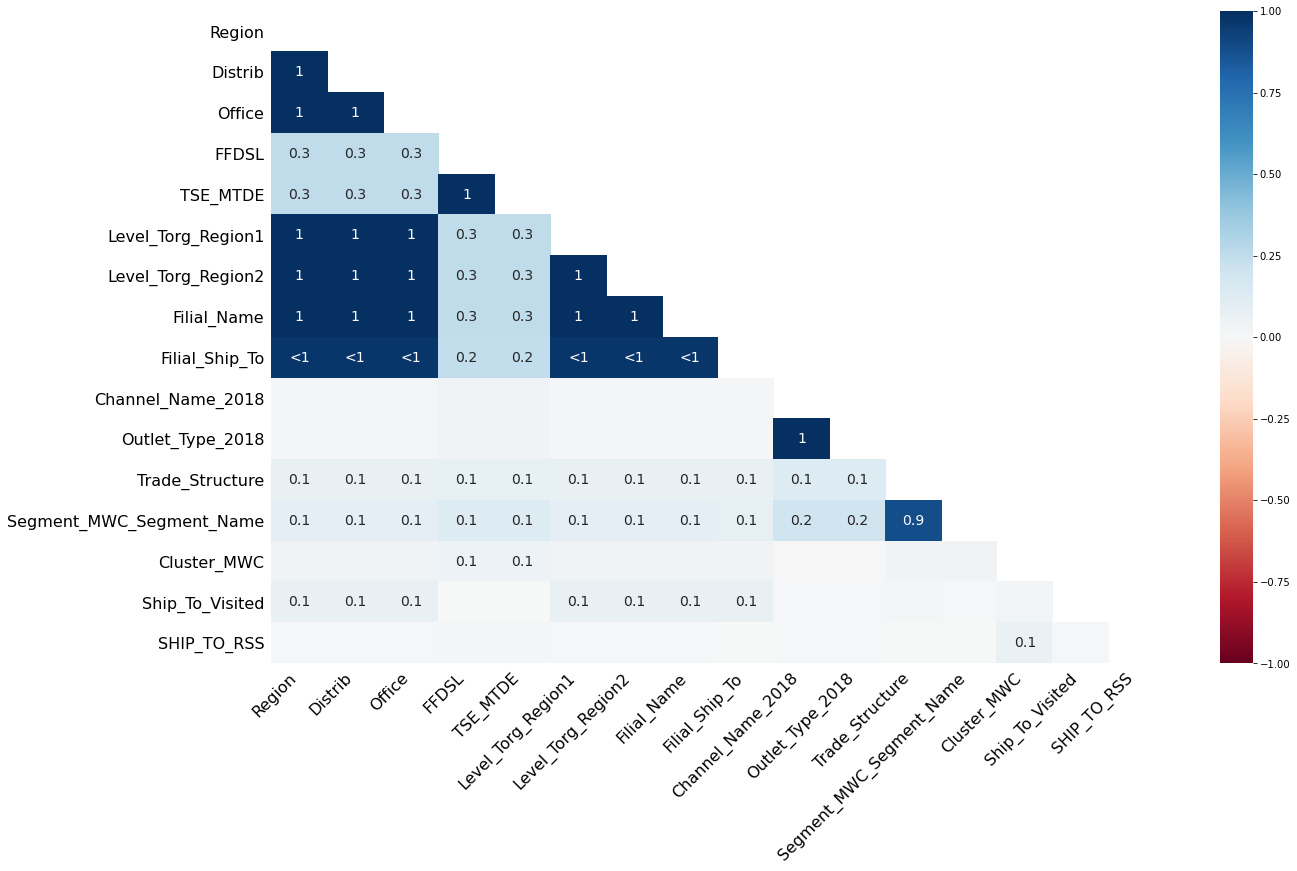

In [27]:
msno.heatmap(df)

### Сохраним текущий набор данных для дальнейших экспериментов

In [28]:
df['From_Dc'] = df['From_Dc'].astype(int)
df['Chain_Id'] = df['Chain_Id'].astype(str)
# Установить поле как индекс, тем самым исключив его из списка признаков
df.set_index('SWE_Store_Key',inplace=True)
df_for_experiments = df.copy()

## Получение модели и проведение экспериментов

### Выбор метрики

Для мультиклассовой классификации, в условиях несбалансированной выборки, допустимо использовать несколько различных метрик https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics. Для нашей задачи будем использовать метрику balanced_accuracy_score, которая определяется как средняя величина полноты (recall), полученная по каждому классу.

В случае, если классификатор работает одинаково хорошо для всех классов, то эта метрика работает как обычная точность, то есть отношение правильных предсказаний к общему количеству предсказаний. Если же обычная точность выше вероятности только потому, что классификатор использует несбалансированный набор тестов, тогда сбалансированная точность, в зависимости от ситуации, снизится до 1/n_classes (https://scikit-learn.org/stable/modules/model_evaluation.html#balanced-accuracy-score).

### Выбор базового классификатора
Для задачи классификации удобно использовать классификатор RandomForestClassifier. По моему опыту этот ансамблевый метод часто показывает лучшие результаты обучения. Согласно https://ru.wikipedia.org/wiki/Random_forest#%D0%94%D0%BE%D1%81%D1%82%D0%BE%D0%B8%D0%BD%D1%81%D1%82%D0%B2%D0%B0 имеет следующие достоинства:
- Способность эффективно обрабатывать данные с большим числом признаков и классов.
- Нечувствительность к масштабированию (и вообще к любым монотонным преобразованиям) значений признаков.
- Одинаково хорошо обрабатываются как непрерывные, так и дискретные признаки.

Будем использовать RandomForestClassifier для экспериментов, а потом сравним его с другими классификаторами

In [29]:
rfc = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

### Разделение на тренировочную и валидационную выборку

Функция get_data делит данные на тренировочную и валидационную выборку в соотношении 70 на 30 с контролем стратификации по целевой переменной (чтобы обеспечить попадание целевых значений и в тренировочную и валидационную выборки). При этом определяются (функцией get_ships_to_exclude) и отбрасываются классы в которых меньше двух сэмплов (в противном случае будет ошибка при разделении).

In [335]:
def get_ships_to_exclude(df, threshold=2):
    """
    Вернуть список классов с количеством сэмплов меньшим threshold
   
    """
    if threshold < 2:
        threshold = 2
    ship_counts = df[~df['SHIP_TO_RSS'].isna()].groupby('SHIP_TO_RSS').size().to_frame()
    ship_counts.reset_index(inplace=True)
    ship_counts.columns = ['SHIP_TO_RSS','Counts']
    
    return [str(item) for item in list(ship_counts['SHIP_TO_RSS'][ship_counts['Counts']<threshold].values)]


def get_encoded(X, y):
    """
    Преобразует категорийные признаки в OrdinalEncoder, а целевую переменную в LabelEncoding
    
    """
    cat_features = X.select_dtypes(include=['object']).columns  # Categorical
    num_features = X.select_dtypes(exclude=['object']).columns  # Numeric
    # Преобразование категорийных признаков
    oe = OrdinalEncoder()
    X_cat = oe.fit_transform(X[cat_features])
    # Преобразование числовых признаков (не выполняем)
    X_num = X[num_features]
    # scaler = MinMaxScaler()
    # scaler.fit(X[num_features])
    # X_train_num = scaler.transform(X_train[num_features])
    # X_valid_num = scaler.transform(X_valid[num_features])
    # Объединить категорийные и числовые
    X_enc = np.hstack([X_cat, X_num])
    # Преобразование y
    le = LabelEncoder()
    y_enc = le.fit_transform(y)

    return X_enc, y_enc 


def get_data(drop_na=True, list_of_features=None, samples_threshold=2, get_data_info=False, do_encode=False):
    """
    Получить наборы данных
    
    Parameters:
    drop_na (boolean)        : True - удалить строки с пустыми значениями, False - выполнить замену пропусков
    list_of_features (list)  : Список признаков, которые нужно оставить
    samples_threshold (int)  : Удалить классы с количеством сэмплов меньше чем samples_threshold
        
    Returns:
    X, y, X_train, X_valid, y_train, y_valid (array-like)

    """
    df = df_for_experiments.copy()

    cat_features = df.select_dtypes(include=['object']).columns  # Categorical
    num_features = df.select_dtypes(exclude=['object']).columns  # Numeric

    # Временно заменяем пропущенные значения
    df['SHIP_TO_RSS'].replace(np.NaN, 0, inplace=True)
    if drop_na:
        # Очистка строк с пропущенными значениями
        df.dropna(axis=0, inplace=True)
    else:
        # Замена пропущенных значений
        for name in cat_features:
            df[name].fillna('missing', inplace=True)
        for name in num_features:
            df[name].fillna(0, inplace=True)
    df['SHIP_TO_RSS'].replace(0, np.NaN, inplace=True)

    target = ['SHIP_TO_RSS']         # Целевая переменная
    service = ['isTrain','isCoord']  # Сервисные признаки, которые отбросить
    # Из полного списка признаков или из переданного списка признаков исключить target & service
    features = [column for column in \
                    (df.columns if list_of_features==None else list_of_features) \
                    if column not in target and column not in service]
    # Классы для исключения
    ships_to_exclude = get_ships_to_exclude(df, samples_threshold)
    # Вернуть наборы данных с нужными признаками и оставшимися классами
    X = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships_to_exclude))][features]
    y = df[(df['isTrain']==True)&(~df['SHIP_TO_RSS'].isin(ships_to_exclude))][target]
    y['SHIP_TO_RSS'] = y['SHIP_TO_RSS'].astype(int)
    
    if do_encode:
        # Выполнить кодирование признаков
        X, y = get_encoded(X, y)
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    if get_data_info:
        print(f'Размер выборки total: {X.shape[0]}, train: {X_train.shape[0]}, valid: {X_valid.shape[0]}')
        print(f"Количество признаков: {len(features)} ({', '.join(features)})")
    
    return X, y, X_train, X_valid, y_train, y_valid

### Эксперимент. Отбор признаков

Для первичного отбора признаков воспользуемся функцией mutual_info_classif из sklearn.feature_selection, которая определяет важность признаков, вычисляя взаимную информацию. Взаимная информация рассчитывается между двумя переменными и измеряет уменьшение неопределенности для одной переменной при известном значении другой переменной.
https://machinelearningmastery.com/information-gain-and-mutual-information

mutual_info_classif() function https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.mutual_info_classif.html

In [31]:
encoder = OrdinalEncoder()
X, y, X_train, X_valid, y_train, y_valid = get_data(drop_na=False)
# Обучить энкодер и трансформировать признаки
encoder.fit(X)
X_train_enc = encoder.transform(X_train)
fs = mutual_info_classif(X_train_enc, y_train, random_state=42)

Оставим самые важные признаки, отбросив признаки с важностью менее 20% от самого важного и визуализируем

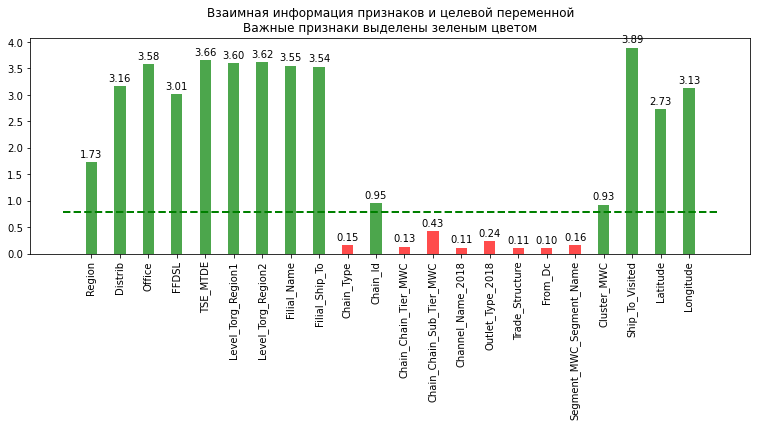

Важные признаки: Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Id, Cluster_MWC, Ship_To_Visited, Latitude, Longitude


In [32]:
def get_important_features(feature_importance, threshold=0.2, do_show=True):
    relative_threshold = feature_importance['importance'].max() * threshold
    selected_features = []
    for feat, score in zip(feature_importance['features'], feature_importance['importance']):
        if score > relative_threshold:
            selected_features.append(feat)
    if do_show:
        # График
        fig = plt.figure(figsize=(10,3))
        axes = fig.add_axes([0, 0, 1, 1])
        axes.set_title('Взаимная информация признаков и целевой переменной\nВажные признаки выделены зеленым цветом')

        # Зададим цвета важных и прочих признаков
        mask = feature_importance['importance'] < relative_threshold
        colors = np.array(['g']*len(feature_importance['importance']))
        colors[mask] = 'r'
        # График
        rects = axes.bar(x = feature_importance['features'],
                 height = feature_importance['importance'],
                 width = 0.4, alpha = 0.7, color=colors)
        # Повернуть названия признаков
        for tick in axes.get_xticklabels():
            tick.set_rotation(90)

        for rect in rects:
            h = rect.get_height()
            axes.annotate(f'{h:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, h),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
        # Нарисовать линию
        plt.plot([-1,len(feature_importance['features'])], [relative_threshold,relative_threshold],
                 color='green', linestyle='dashed', linewidth=2)
        plt.show()
    
    return selected_features


# Создадим словарь 
mic_feature_importance = {'features':list(X_train.columns), 'importance':fs}
mic_selected_features = get_important_features(mic_feature_importance, 0.2, True)
print(f"Важные признаки: {', '.join(mic_selected_features)}")

### Оценка модели

Для обучения и валидации модели используем процедуру get_model, которая реализует конвейер данных (Pipeline) в котором выполняется замена пропущенных значений, а также кодирование в соответствии с заданным энкодером.

In [33]:
def get_prediction_result(X, X_train, X_valid, y_valid, y_pred, hierarchy=True):
    """
    Строит сводную таблицу для количественного анализа предсказаний модели

    Parameters:
    X (array-like)      : Исходный набор признаков без целевого
    X_train (array-like): Набор признаков для обучения
    X_valid (array-like): Набор признаков для валидации
    y_valid (array-like): Целевой признак для валидации
    hierarchy (boolean) : True - включать в анализ расчеты по иерархиям
        
    Returns:
    pandas.DataFrame    : Сводная таблица

    """
    rdf = pd.DataFrame()

    # Сколько всего записей в тестовом наборе данных
    test = X.copy()
    test['SHIP_TO_RSS'] = y['SHIP_TO_RSS']
    test.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count()
    rdf['SHIP_TO_RSS'] = test.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count()
    rdf.columns = ['test_samples_counts']

    # Подсчитаем сколько записей в тренировочном наборе
    train = X_train.copy()
    train['SHIP_TO_RSS'] = y_train['SHIP_TO_RSS']
    train_df = train.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
    train_df.columns = ['train_samples_counts']
    rdf.loc[train_df.index,'train_samples_counts'] = \
        train_df['train_samples_counts']

    # Подсчитаем сколько записей в валидационном наборе
    valid = X_valid.copy()
    valid['SHIP_TO_RSS'] = y_valid['SHIP_TO_RSS']
    valid_df = valid.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
    valid_df.columns = ['valid_samples_counts']
    rdf.loc[valid_df.index,'valid_samples_counts'] = \
        valid_df['valid_samples_counts']

    # Подсчитаем количество ошибочных предсказаний
    y_comp = y_valid.copy()
    y_comp['SHIP_TO_RSS_PRED'] = y_pred
    y_wrong = y_comp[y_comp['SHIP_TO_RSS']!=y_comp['SHIP_TO_RSS_PRED']]
    y_wrong_df = y_wrong.groupby('SHIP_TO_RSS').SHIP_TO_RSS.count().to_frame()
    y_wrong_df.columns = ['wrong_predicted_counts']
    rdf.loc[y_wrong_df.index,'wrong_predicted_counts'] = \
        y_wrong_df['wrong_predicted_counts']

    # Ошибка в процентах от количества записей в проверочном наборе данных
    rdf['wrong_predicted_percentage'] = \
        rdf['wrong_predicted_counts'] / \
        rdf['valid_samples_counts'] * 100

    if hierarchy:
        # Посчитаем сколько всего записей с иерархиями дистрибьюторов и сотрудников
        test['dist_hierarchy_exists'] = test['Region']!='missing'
        test['associates_hierarchy_exists'] = test['FFDSL']!='missing'

        dist_exists_df = test[test['dist_hierarchy_exists']==True]. \
            groupby(['SHIP_TO_RSS','dist_hierarchy_exists']).dist_hierarchy_exists.count().to_frame()
        dist_exists_df.columns = ['dist_hierarchy_exists_counts']
        dist_exists_df.reset_index(inplace=True)
        dist_exists_df.set_index('SHIP_TO_RSS',inplace=True)
        dist_exists_df.drop('dist_hierarchy_exists',axis=1,inplace=True)

        assoc_exists_df = test[test['associates_hierarchy_exists']==True]. \
            groupby(['SHIP_TO_RSS','associates_hierarchy_exists']).associates_hierarchy_exists.count().to_frame()
        assoc_exists_df.columns = ['associates_hierarchy_exists_counts']
        assoc_exists_df.reset_index(inplace=True)
        assoc_exists_df.set_index('SHIP_TO_RSS',inplace=True)
        assoc_exists_df.drop('associates_hierarchy_exists',axis=1,inplace=True)

        rdf.loc[dist_exists_df.index,'dist_hierarchy_exists_counts'] = \
            dist_exists_df['dist_hierarchy_exists_counts']
        rdf.loc[assoc_exists_df.index,'associates_hierarchy_exists_counts'] = \
            assoc_exists_df['associates_hierarchy_exists_counts']

        rdf['dist_hierarchy_exists_percentage'] = \
            rdf['dist_hierarchy_exists_counts'] / \
            rdf['test_samples_counts'] * 100

        rdf['associates_hierarchy_exists_percentage'] = \
            rdf['associates_hierarchy_exists_counts'] / \
            rdf['test_samples_counts'] * 100

        fields_to_output = ['test_samples_counts','wrong_predicted_percentage',
                            'dist_hierarchy_exists_percentage','associates_hierarchy_exists_percentage']
        
    else:
        fields_to_output = ['test_samples_counts','wrong_predicted_percentage']
    
    return rdf.loc[:,(fields_to_output)].sort_values('wrong_predicted_percentage',ascending=False)

In [34]:
def get_model(classifier, encoder, do_val=True, do_xval=True,
              drop_na=True, list_of_features=None, samples_threshold=2, get_data_info=False,
              do_pred_result=False):
    """
    Подготовить Pipeline

    Parameters:
    X_train (array-like)  : Набор данных для обучения
    y_train (array-like)  : Целевые значения для обучения
    classifier            : Классификатор, например, rfc
    encoder
    do_val (boolean)      : True - выполнить обучение
        
    Returns:
    sklearn.pipeline.Pipeline

    """

    # Собрать характеристики обучения модели
    model_name = "Model footprint:, "
    model_name += f"{'All features' if list_of_features==None else 'Selected Features'}, "
    model_name += f"{type(classifier)}, {type(encoder)}, "
    model_name += f"{'drop_na' if drop_na else 'fill_na'}, "
    model_name += f"{'All classes' if samples_threshold==2 else 'Big classes'}, "
    # Вывести на отдельных строках
    mn = model_name.replace(",","\n")
    print(f"{mn}-----------------------------------------------------------------")

    X, y, X_train, X_valid, y_train, y_valid = \
        get_data(drop_na=drop_na, list_of_features=list_of_features,
                 samples_threshold=samples_threshold, get_data_info=get_data_info)
        
    cat_features = X_train.select_dtypes(include=['object']).columns  # Categorical
    num_features = X_train.select_dtypes(exclude=['object']).columns  # Numeric
    
    cat_pipe = Pipeline([
                        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                        ('encoder', encoder),
#                         ('encoder', OneHotEncoder(handle_unknown='ignore')),
                    ])
    num_pipe = Pipeline([
                        ('imputer', SimpleImputer(strategy='mean')),
                    ])
    preprocessing = ColumnTransformer([
                            ('cat', cat_pipe, cat_features),
                            ('num', num_pipe, num_features),
                    ])
    model = Pipeline([
        ('preprocess', preprocessing),
        ('classifier', classifier),
    ])
    
    # Валидация
    val_score = 0
    t1 = 0
    if do_val:
        t0 = time()
        model.fit(X_train, y_train.values.ravel())
        y_pred = model.predict(X_valid)
        val_score = balanced_accuracy_score(y_valid, y_pred)
        print(f"Accuracy Score отложенной выборки: {val_score:.3f}")
        t1 = time() - t0
        print(f"Выполнено за {t1:.3f} сек.")
    # Кросс-валидация
    cv = 3
    xval_scores = np.arange(3) * 0
    t2 = 0
    if do_xval:
        t0 = time()
        xval_scores = cross_val_score(model, X, y, cv=cv, scoring='balanced_accuracy')
        xval_scores = np.array([round(item,5) for item in xval_scores])
        print(f"Средняя оценка при кросс-валидации: {xval_scores.mean():.3f}")
        t2 = time() - t0
        print(f"Выполнено за {t2:.3f} сек.")
    
    model_dict = {'model_name':model_name, 'val_score':val_score, 't1':t1, 'xval_scores':xval_scores,
                  'xval_scores_mean':xval_scores.mean(), 't2':t2, 'samples_threshold':samples_threshold,
                  'features':X.columns.values}
    stat_data.append(model_dict)
    print("\n")
    
    df_pred_result = pd.DataFrame()
    if do_pred_result:
        df_pred_result = get_prediction_result(X, X_train, X_valid, y_valid, y_pred,
                                                        hierarchy=drop_na==False)

    return model, y_pred, val_score, xval_scores, df_pred_result

**В переменную stat_data будем собирать статистику экспериментов**

In [35]:
stat_data = []

### Эксперимент. Сравнение модели с отобранными признаками с моделью со всеми признаками

In [36]:
ordinal_encoder = ce.ordinal.OrdinalEncoder()

# Отобранные признаки
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, ordinal_encoder, drop_na=False, list_of_features=mic_selected_features, get_data_info=False)

# Все признаки
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, ordinal_encoder, drop_na=False, list_of_features=None, get_data_info=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 fill_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.945
Выполнено за 2.939 сек.
Средняя оценка при кросс-валидации: 0.922
Выполнено за 7.983 сек.


Model footprint:
 All features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 fill_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.934
Выполнено за 3.224 сек.
Средняя оценка при кросс-валидации: 0.926
Выполнено за 8.600 сек.




In [37]:
ms = pd.DataFrame(data=stat_data)
ms.loc[:,('model_name','val_score','xval_scores_mean','xval_scores')]

,model_name,val_score,xval_scores_mean,xval_scores
0,"Model footprint:, Selected Features, <class 's...",0.945127,0.92185,"[0.92671, 0.93887, 0.89997]"
1,"Model footprint:, All features, <class 'sklear...",0.933869,0.92590,"[0.93065, 0.94831, 0.89874]"


**Из проведенного эксперимента видно, что при обучении на выбранном наборе признаков точность модели выше.** Тем не менее в последующих экспериментах будем проверять оба варианта, где это применимо.

### Эксперимент. Сравнение OrdinalEncoder vs OneHotEncoder

Набор данных содержит категорийные признаки, которые в исходном виде нельзя использовать при обучении. Энкодер OrdinalEncoder заменяет текстовые значения на числовые, в то время как OneHotEncoder для каждого признака создает новые бинарные столбцы в таком количестве, сколько значений категорийного признака. 

In [38]:
# OneHotEncoder, выбранные признаки
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')

# Выбранные признаки
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, one_hot_encoder, list_of_features=mic_selected_features, get_data_info=False)

# Все признаки
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, one_hot_encoder, list_of_features=None, get_data_info=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.944
Выполнено за 5.038 сек.
Средняя оценка при кросс-валидации: 0.938
Выполнено за 10.047 сек.


Model footprint:
 All features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 drop_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.948
Выполнено за 5.171 сек.
Средняя оценка при кросс-валидации: 0.941
Выполнено за 12.811 сек.




In [39]:
ms = pd.DataFrame(data=stat_data)
ms.loc[:,('model_name','val_score','xval_scores_mean','xval_scores')]

,model_name,val_score,xval_scores_mean,xval_scores
0,"Model footprint:, Selected Features, <class 's...",0.945127,0.92185,"[0.92671, 0.93887, 0.89997]"
1,"Model footprint:, All features, <class 'sklear...",0.933869,0.92590,"[0.93065, 0.94831, 0.89874]"
2,"Model footprint:, Selected Features, <class 's...",0.944260,0.93777,"[0.9333, 0.94752, 0.93249]"
3,"Model footprint:, All features, <class 'sklear...",0.947690,0.94103,"[0.93693, 0.95368, 0.93248]"


Из сводной таблицы видно, что кодирование OneHotEncoder позволяет получить лучшую точность, *особенно это заментно из результатов кросс-валидации*. При этом обучение на полном наборе признаков дает лучший результат, чем на отобранном (в OrdinalEncoder наоборот). В дальнейших экспериментах используем OneHotEncoder.

### Эксперимент. Зависимость относительной ошибки предсказания от размера класса

Проверим гипотезу, что для классов с небольшим количеством сэмплов относительная ошибка неверных предсказаний будет выше. Для проведения анализа будем собирать агрегированную информацию по каждому классу.

In [40]:
# Все классы (samples_threshold=2)
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, one_hot_encoder, drop_na=False, list_of_features=mic_selected_features, samples_threshold=2,
              get_data_info=False,
              do_xval=True, do_pred_result=True)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 fill_na
 All classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.925
Выполнено за 7.085 сек.
Средняя оценка при кросс-валидации: 0.925
Выполнено за 13.667 сек.




Слева отсортируем классы в порядке возрастания количества точек, а ниже покажем относительную ошибку. Справа отсортируем классы в порядке убывания ошибки, а ниже покажем количество точек в классах

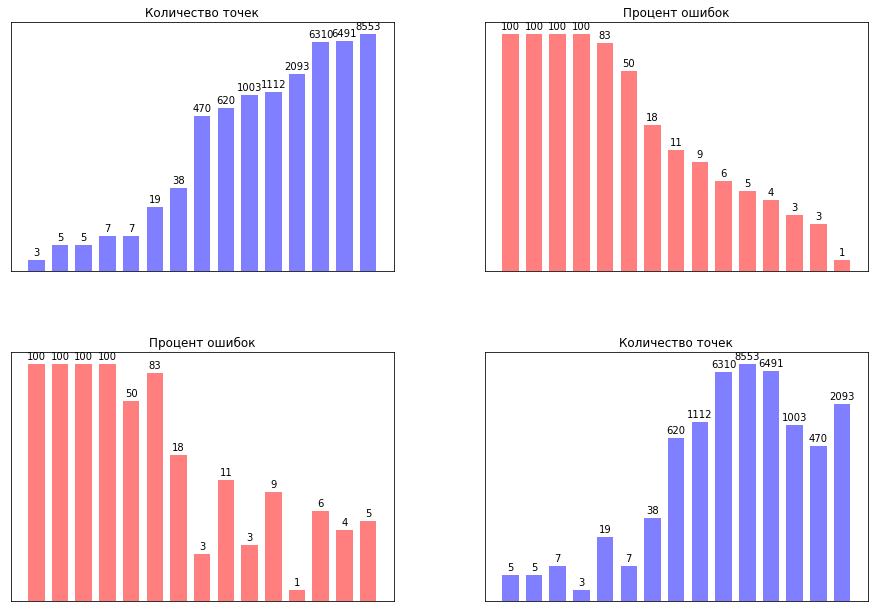

In [42]:
def paint_bars(axes, x, height, title, color, round_to=0, show_xaxes=False):
    """
    Строит bar на графике
    
    Parameters:
    axes, x, height            : Ось для нанесения bar с категориями x и высотой height
    title                      : Заголовок
    color                      : Цвет
    round_to                   : Округлить значения на анотациях bars
    show_xaxes                 : Показать подписи x-оси
    """
    
    rects = axes.bar(x = x, height = height, width = 0.7,
        align = 'center', alpha = 0.5, log=True, color=color)
    for tick in axes.get_xticklabels():
        tick.set_rotation(90)
    axes.set_title(title)
#     axes.set_ylabel('Шкала логарифмическая')
    for rect in rects:
        h = rect.get_height()
        axes.annotate(f'{int(round(h,round_to))}' if round_to==0 else f'{round(h,round_to):.{round_to}f}',
                    xy=(rect.get_x() + rect.get_width() / 2, h),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    axes.get_xaxis().set_visible(show_xaxes)
    axes.get_yaxis().set_visible(False)

    return axes


fig, axes = plt.subplots(2,2,figsize=(14,10))
fig.tight_layout(pad=6.0)
df_aux = df_pred_result.iloc[:15].sort_values('test_samples_counts',ascending=True)
axes[0,0] = paint_bars(axes[0,0], df_aux.index.astype('str'), df_aux['test_samples_counts'],
                        'Количество точек', 'b')
axes[1,0] = paint_bars(axes[1,0], df_aux.index.astype('str'), df_aux['wrong_predicted_percentage'],
                        'Процент ошибок', 'r')
df_aux = df_pred_result.iloc[:15].sort_values('wrong_predicted_percentage',ascending=False)
axes[1,1] = paint_bars(axes[1,1], df_aux.index.astype('str'), df_aux['test_samples_counts'],
                        'Количество точек', 'b')
axes[0,1] = paint_bars(axes[0,1], df_aux.index.astype('str'), df_aux['wrong_predicted_percentage'],
                        'Процент ошибок', 'r')
plt.show()

Из проведенного эксперимента видно, что из 12 классов с количеством точек до 100, есть 5 классов с относительной ошибкой больше 50 процентов. Согласовали с бизнесом, что по классам с количеством точек меньше 25 целевую переменную не предсказываем, но сообщаем пользователю список этих классов. В дальнейших экспериментах исключаем такие классы из обучения.

**Посмотрим, повысится ли точность, если исключить из данных классы с количеством точек меньшим 25.**

In [43]:
# Классы с количеством сэмплов больше 25 (samples_threshold=25)
model, y_pred, val_score, xval_scores, _ = \
    get_model(rfc, one_hot_encoder, drop_na=False, list_of_features=mic_selected_features,
              get_data_info=False, samples_threshold=25)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 fill_na
 Big classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.992
Выполнено за 5.835 сек.
Средняя оценка при кросс-валидации: 0.977
Выполнено за 10.545 сек.




Значительно повысилась. Неудивительно, ведь balanced accuracy score учитывает несбалансированность классов. Исключив классы с самой высокой относительной ошибкой предсказаний мы повысили точность. __Обратите внимание, мы не  не продолжаем улучшать работу модели с маленькими классами поскольку это является ошибкой входных данных: с одного адреса доставки не может грузиться мало точек.__

### Эксперимент. Как отсутствие иерархий влияет на ошибки предсказания?

Обучим модель, заменив пропуски (*drop_na=False*) и определяя замененные значения, как факт отсутствия иерархии (напомним, что у нас имеется две иерархии: дистрибьюторов и сотрудников). Построим графики с типом bar для первых 15-ти классов с наибольшей относительной ошибкой (*do_pred_result=True возвращает посчитанную таблицу для анализа*).

In [44]:
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, one_hot_encoder, drop_na=False, list_of_features=mic_selected_features,
              get_data_info=False, samples_threshold=25, do_pred_result=True)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 fill_na
 Big classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.992
Выполнено за 6.030 сек.
Средняя оценка при кросс-валидации: 0.977
Выполнено за 10.191 сек.




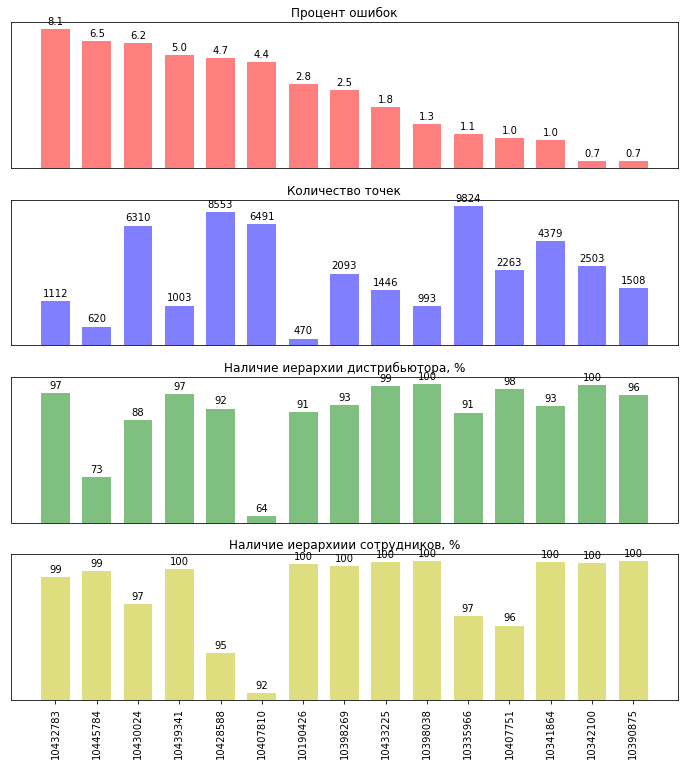

In [45]:
fig, axes = plt.subplots(4,1,figsize=(10,10))
fig.tight_layout()
df_aux = df_pred_result.iloc[:15].sort_values('wrong_predicted_percentage',ascending=False)

axes[0] = paint_bars(axes[0], df_aux.index.astype('str'), df_aux['wrong_predicted_percentage'],
                        'Процент ошибок', 'r', 1)
axes[1] = paint_bars(axes[1], df_aux.index.astype('str'), df_aux['test_samples_counts'],
                        'Количество точек', 'b', 0)
axes[2] = paint_bars(axes[2], df_aux.index.astype('str'), df_aux['dist_hierarchy_exists_percentage'],
                        'Наличие иерархии дистрибьютора, %', 'g',0)
axes[3] = paint_bars(axes[3], df_aux.index.astype('str'), df_aux['associates_hierarchy_exists_percentage'],
                        'Наличие иерархиии сотрудников, %', 'y', 0, show_xaxes=True)

Убеждаемся, что не смотря на то, что для классов с максимальной ошибкой отсутствие иерархий имеет место быть, для последующих классов мы видим, что относительная ошибка уменьшается, а наличие иерархий не имеет выраженного  патерна. Делаем вывод, что **наличие/отсутствие иерархий не оказывает заметного влияния на ошибки**.

### Эксперимент. Исключение данных с пропущенными значениями

Поскольку пропущенные значения разных признаков имеют одинаковую специальную метку, в момент кодировки OneHotEncoder, это может отрицательно влиять на процесс обучения. Попробуем удалить данные с пропущенными значениями (*drop_na=True*), тем более, что их не больше 10% от общего количества.

In [46]:
# Удалить пропущенные значения
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, one_hot_encoder, drop_na=True, list_of_features=mic_selected_features,
              get_data_info=False, samples_threshold=25, do_pred_result=True)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 drop_na
 Big classes
 -----------------------------------------------------------------
Accuracy Score отложенной выборки: 0.993
Выполнено за 4.251 сек.
Средняя оценка при кросс-валидации: 0.984
Выполнено за 8.024 сек.




Мы получили ещё больший score при валидации и кросс-валидации. Визуализируем

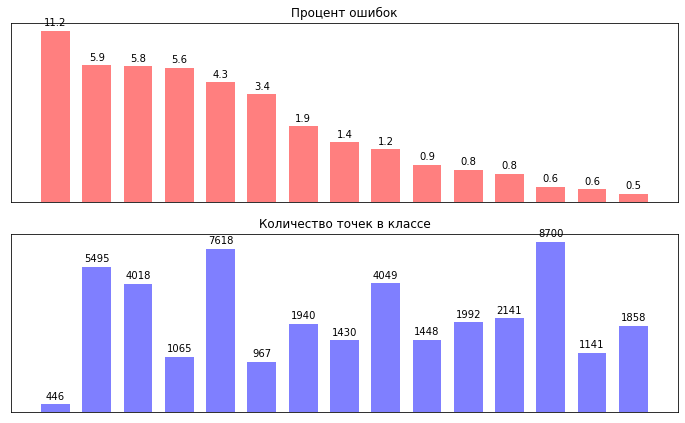

In [47]:
fig, axes = plt.subplots(2,1,figsize=(10,6))
fig.tight_layout()
df_aux = df_pred_result.iloc[:15].sort_values('wrong_predicted_percentage',ascending=False)

axes[0] = paint_bars(axes[0], df_aux.index.astype('str'), df_aux['wrong_predicted_percentage'],
                        'Процент ошибок', 'r', 1)
axes[1] = paint_bars(axes[1], df_aux.index.astype('str'), df_aux['test_samples_counts'],
                        'Количество точек в классе', 'b', 0)

В результате эксперимента принимаем подход с удалением строк с пропущенными значениями, т.к. на валидации повышается точность модели.

In [48]:
# Результаты последних 2-х экспериментов
ms = pd.DataFrame(data=stat_data)
ms.iloc[-2:].loc[:,('val_score','xval_scores_mean','xval_scores')]

,val_score,xval_scores_mean,xval_scores
6,0.992346,0.976787,"[0.97792, 0.98584, 0.9666]"
7,0.992927,0.983657,"[0.97783, 0.98673, 0.98641]"


### Эксперимент. Сравнение важности признаков из модели RandomForestClassifier с полученными из Mutual Information Classificator

Чтобы получать информацию о важности исходных признаков будем использовать OrdinalEncoder (OneHotEncoder создает много двоичных признаков которые сложно анализировать).

**Важность признаков из Mutual Information Classifier**

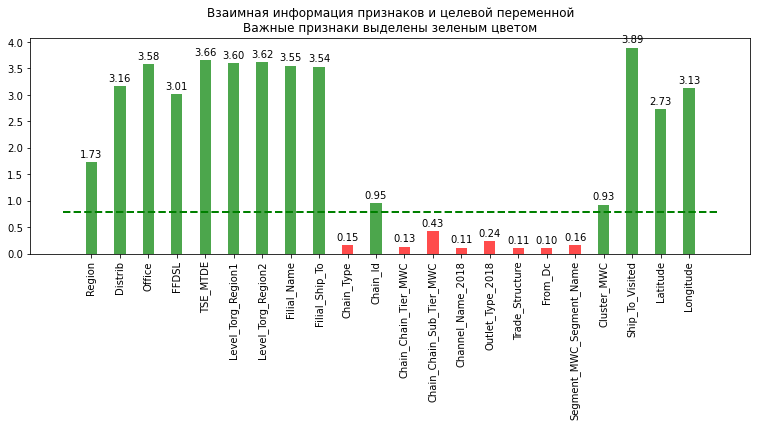

In [49]:
mic_selected_features_20 = get_important_features(mic_feature_importance, 0.2)

In [50]:
# Зададим явный набор признаков
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, ordinal_encoder, drop_na=True, list_of_features=mic_selected_features_20,
              get_data_info=True, do_xval=True, samples_threshold=25, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 Big classes
 -----------------------------------------------------------------
Размер выборки total: 184662, train: 129263, valid: 55399
Количество признаков: 14 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Id, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.994
Выполнено за 1.959 сек.
Средняя оценка при кросс-валидации: 0.983
Выполнено за 4.606 сек.




**Важность признаков из классификатора RandomForestClassifier**

Обучим модель на всех признаках и получим важность признаков из классификатора

In [51]:
# Зададим явный набор признаков (все признаки)
all_features = [item for item in list(df.columns.values) if item not in ['SHIP_TO_RSS','isCoord','isTrain']]
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, ordinal_encoder, drop_na=True, list_of_features=all_features,
              get_data_info=True, do_xval=True, samples_threshold=25, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 Big classes
 -----------------------------------------------------------------
Размер выборки total: 184662, train: 129263, valid: 55399
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.995
Выполнено за 2.514 сек.
Средняя оценка при кросс-валидации: 0.986
Выполнено за 6.221 сек.




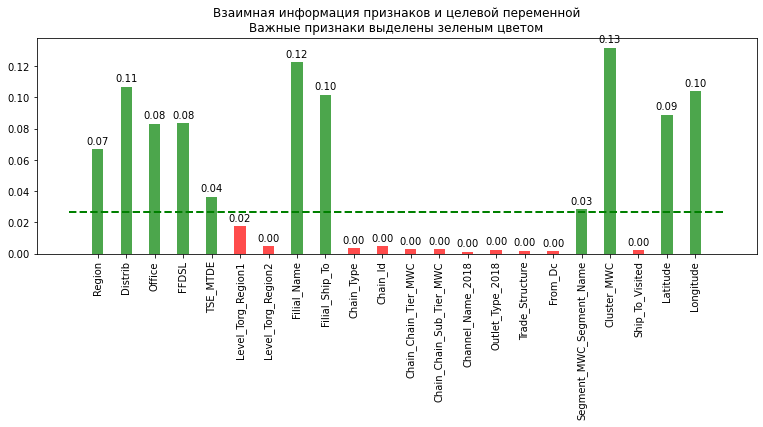

Важные признаки полученные из классификатора: Region, Distrib, Office, FFDSL, TSE_MTDE, Filial_Name, Filial_Ship_To, Segment_MWC_Segment_Name, Cluster_MWC, Latitude, Longitude


In [54]:
# Получить объект с классификатором
rfc = model.named_steps['classifier']
# Создадим словарь Признаки-Важность
rfc_feature_importance = {'features':all_features, 'importance':rfc.feature_importances_}

rfc_selected_features_20 = get_important_features(rfc_feature_importance, 0.2)
print(f"Важные признаки полученные из классификатора: {', '.join(rfc_selected_features_20)}")

Интересно отметить, что классификатор занизил важность признаков Ship_To_Visited, Level_Torg_Region1, Level_Torg_region2. Отбросим признаки с низкой важностью и обучим модель на отобранных признаках.

In [55]:
# Обучим на отобранных признаках
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, ordinal_encoder, drop_na=True, list_of_features=rfc_selected_features_20,
              get_data_info=True, do_xval=True, samples_threshold=25, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 Big classes
 -----------------------------------------------------------------
Размер выборки total: 184662, train: 129263, valid: 55399
Количество признаков: 11 (Region, Distrib, Office, FFDSL, TSE_MTDE, Filial_Name, Filial_Ship_To, Segment_MWC_Segment_Name, Cluster_MWC, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.973
Выполнено за 1.496 сек.
Средняя оценка при кросс-валидации: 0.967
Выполнено за 3.808 сек.




Точность модели ухудшилась. Попробуем взять все признаки с относительным вкладом выше 10%

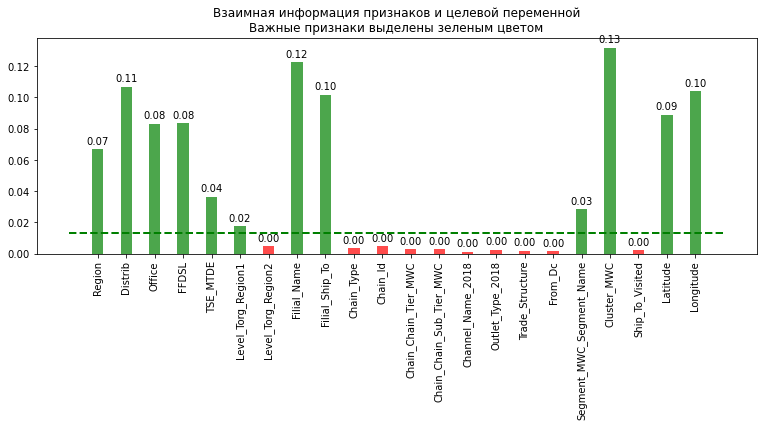

Важные признаки полученные из классификатора: Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Filial_Name, Filial_Ship_To, Segment_MWC_Segment_Name, Cluster_MWC, Latitude, Longitude


In [57]:
rfc_selected_features_10 = get_important_features(rfc_feature_importance, 0.1)
print(f"Важные признаки полученные из классификатора: {', '.join(rfc_selected_features_10)}")

In [58]:
# Зададим явный набор признаков
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, ordinal_encoder, drop_na=True, list_of_features=rfc_selected_features_10,
              get_data_info=True, do_xval=True, samples_threshold=25, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'category_encoders.ordinal.OrdinalEncoder'>
 drop_na
 Big classes
 -----------------------------------------------------------------
Размер выборки total: 184662, train: 129263, valid: 55399
Количество признаков: 12 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Filial_Name, Filial_Ship_To, Segment_MWC_Segment_Name, Cluster_MWC, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.975
Выполнено за 1.507 сек.
Средняя оценка при кросс-валидации: 0.968
Выполнено за 4.080 сек.




Проведенный эксперимент показал, что признаки Ship_To_Visited, Level_Torg_Region1, Level_Torg_region2 важны для модели и поэтому их убирать нельзя.

In [59]:
# Результаты последних 6-х экспериментов
ms = pd.DataFrame(data=stat_data)
ms.iloc[-6:].loc[:,('val_score','xval_scores_mean','xval_scores')]

,val_score,xval_scores_mean,xval_scores
6,0.992346,0.976787,"[0.97792, 0.98584, 0.9666]"
7,0.992927,0.983657,"[0.97783, 0.98673, 0.98641]"
8,0.993666,0.982553,"[0.97493, 0.98622, 0.98651]"
9,0.994807,0.985740,"[0.97974, 0.99006, 0.98742]"
10,0.972704,0.966823,"[0.95304, 0.9688, 0.97863]"
11,0.974931,0.968183,"[0.95619, 0.97005, 0.97831]"


### Эксперимент. Оценка важности признаков в кодировке OneHotEncoder

Обучим модель с полным набором признаков в кодировке OneHotEncoder и визуализируем их важность. Данные будем доставать из объекта Pipeline специальным приемом.

In [60]:
# Полный набор признаков
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(rfc, one_hot_encoder, drop_na=True, list_of_features=all_features,
              get_data_info=True, do_xval=True, samples_threshold=25, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.ensemble._forest.RandomForestClassifier'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 drop_na
 Big classes
 -----------------------------------------------------------------
Размер выборки total: 184662, train: 129263, valid: 55399
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.995
Выполнено за 4.731 сек.
Средняя оценка при кросс-валидации: 0.986
Выполнено за 10.058 сек.




In [61]:
# Разделим признаки на категорийные и числовые (также как это делали в самом Pipeline)
cat_features = X.select_dtypes(include=['object']).columns  # Categorical
num_features = X.select_dtypes(exclude=['object']).columns  # Numeric

# Получить объект OneHotEncoder
ohe = (model.named_steps['preprocess']
       .named_transformers_['cat']
       .named_steps['encoder'])

# Получить названия новых One Hot признаков
cat_ohe_feature_names = ohe.get_feature_names(input_features=cat_features)

# К One Hot признакам присоединить числовые признаки, которые участвовали в обучении модели
feature_names = np.append(cat_ohe_feature_names, num_features)

# Вместо уникальных названий One Hot признаков получить массив исходных названий признаков той же длины
features_raw = []
for fname, fval  in zip(cat_features,ohe.categories_):
    features_raw = np.append(features_raw, [fname] * len(fval))
features_raw = np.append(features_raw, num_features)

# Получить объект с классификатором из которого получим значения важности One Hot признаков
rfc = model.named_steps['classifier']

# Создадим набор данных с тремя столбцами:
# исходный признак, соответствующий ему One Hot признак, значение важности признака из классификатора
df_imp = pd.DataFrame(
        {"Feature":features_raw,
         "FeatureName":feature_names,
         "Importance":rfc.feature_importances_}
    ).sort_values(["Importance"], ascending=False)
# # Визуализируем
# df_imp.groupby('Feature').Importance.median().sort_values(ascending=False) \
#     .plot(kind='bar',figsize=(12,5),title='Важность признаков')

Визуализируем признаки на графике с boxplot, где числовые признаки будут показаны одним значением, в то время как категорийные признаки будут показаны в виде box & whiskers на которых можно оценить статистику распределения признака.

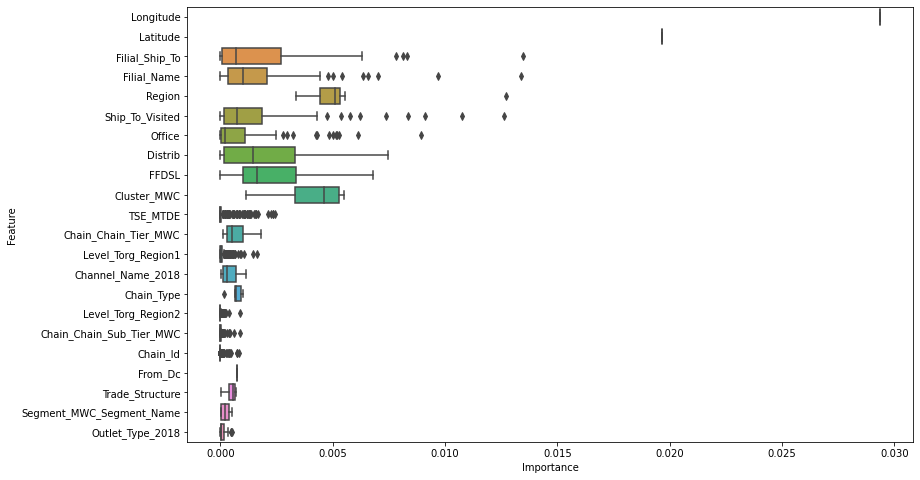

In [62]:
import seaborn as sns
fig, axes = plt.subplots(figsize=(13, 8))
sns.boxplot(data=df_imp, 
            y="Feature", 
            x="Importance", 
           )

Если принять медианное значение важности признака как опорное, то признаки выстраиваются в следующем порядке.

In [63]:
feature_importance_list = list(df_imp.groupby('Feature').Importance.median().sort_values(ascending=False).index)
print(f"Список признаков в порядке убывания важности: {', '.join(feature_importance_list)}")

Список признаков в порядке убывания важности: Longitude, Latitude, Region, Cluster_MWC, FFDSL, Distrib, Filial_Name, From_Dc, Ship_To_Visited, Chain_Type, Filial_Ship_To, Trade_Structure, Chain_Chain_Tier_MWC, Channel_Name_2018, Segment_MWC_Segment_Name, Office, Outlet_Type_2018, Level_Torg_Region1, TSE_MTDE, Level_Torg_Region2, Chain_Chain_Sub_Tier_MWC, Chain_Id


### Эксперимент с исключением One-Hot признаков, с низкой важностью

In [64]:
# Получим наборы данных со всеми признаками
X, y, X_train, X_valid, y_train, y_valid = \
    get_data(drop_na=True, list_of_features=None,
             samples_threshold=25, get_data_info=True)

Размер выборки total: 184662, train: 129263, valid: 55399
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)


In [102]:
# Удалить столбцы по индексам
def dropcols_coo(M, idx_to_drop):
    """ Удаляет столбцы по индексам в разряженной матрице csr
    
    """
    idx_to_drop = np.unique(idx_to_drop)
    C = M.tocoo()
    keep = ~np.in1d(C.col, idx_to_drop)
    C.data, C.row, C.col = C.data[keep], C.row[keep], C.col[keep]
    C.col -= idx_to_drop.searchsorted(C.col)    # decrement column indices
    C._shape = (C.shape[0], C.shape[1] - len(idx_to_drop))

    return C.tocsr()


def get_reduced_one_hot_matrix(X, non_important_features):
    """
    Получает набор данных X, затем преобразует его категорийные признаки в One Hot Encoding, затем
    удаляет столбцы названия которых соответствует названиям элементов из списка non_important_features,
    к получившейся sparse matrix добавляет числовые признаки и возвращает финальный результат
    
    """
    
    # Разделим признаки на категорийные и числовые
    cat_features = X.select_dtypes(include=['object']).columns  # Categorical
    num_features = X.select_dtypes(exclude=['object']).columns  # Numeric
    
    # Трансформация категорийных признаков
    X_cat = X[cat_features]
    ohe = OneHotEncoder(handle_unknown='ignore')
    X_enc = ohe.fit_transform(X_cat)
    
    # Список признаков из обученного ohe
    ohe_feature_names = ohe.get_feature_names(input_features=cat_features)
    
    # Получить индексы не важных признаков в списке One Hot признаков обученного ohe 
    indexes_of_non_imp_features = []
    for i, name in enumerate(ohe_feature_names):
        if name in non_important_features:
            indexes_of_non_imp_features.append(i)
    
    X_reduced = X_enc.copy()
    if len(indexes_of_non_imp_features) > 0:
        # получен список индексов признаков, которые нужно удалить
        X_reduced = dropcols_coo(X_enc, indexes_of_non_imp_features)
    
    # Добавим числовые признаки
    X_reduced = scipy.sparse.hstack([X_reduced, X[num_features]])

    return X_reduced

In [81]:
# Всего признаков
total_features = len(df_imp.FeatureName.values)
# Список пороговых значений для отсечения признаков с низкой важностью
thresholds = [5e-03, 5e-06, 5e-09, 5e-12, 5e-15]
scores_list = []
number_features_list = []

for threshold in thresholds:
    # Список не важных признаков
    df_imp_reduced = df_imp[df_imp['Importance']<threshold]
    features_to_exclude = df_imp_reduced.FeatureName.values
    # Количество признаков для обучения
    number_features = total_features - len(features_to_exclude)
    print(f"Порог: {threshold}, количество важных признаков: {number_features}")
    # Получить sparse matrix только с нужными признаками
    X_reduced = get_reduced_one_hot_matrix(X, features_to_exclude)
    rfc = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)
    scores = cross_val_score(rfc, X_reduced, y, cv=3)
    print(f"Средняя оценка при кросс-валидации: {scores.mean():.4f}")
    scores_list.append(scores.mean())
    number_features_list.append(number_features)

Порог: 0.005, количество важных признаков: 44
Средняя оценка при кросс-валидации: 0.9657
Порог: 5e-06, количество важных признаков: 1531
Средняя оценка при кросс-валидации: 0.9836
Порог: 5e-09, количество важных признаков: 3343
Средняя оценка при кросс-валидации: 0.9842
Порог: 5e-12, количество важных признаков: 4125
Средняя оценка при кросс-валидации: 0.9837
Порог: 5e-15, количество важных признаков: 4149
Средняя оценка при кросс-валидации: 0.9835


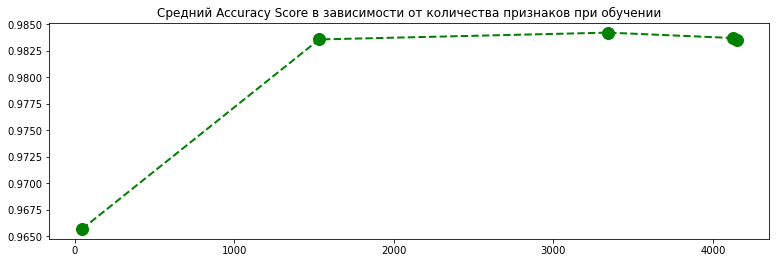

In [97]:
fig = plt.figure(figsize=(10,3))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(number_features_list, scores_list, color='green', marker='o', linestyle='dashed',
    linewidth=2, markersize=12)
axes.set_title(f'Средний Accuracy Score в зависимости от количества признаков при обучении')
plt.show()

Из результатов эксперимента видно, что при допустимо оставить всего 44 самых важных признака, при этом точность всё равно останется хорошей. При увеличении количества  признаков точность возрастает, достигая максимума на 3343 признаках, а затем начинает убывать. 

## Эксперимент. Оценка модели с классификаторами дугих типов

### LogisticRegression 

In [110]:
# LogisticRegression(C=10, class_weight='balanced', dual=False, fit_intercept=True,
#                        intercept_scaling=1, l1_ratio=0.1, max_iter=3000,
#                        multi_class='multinomial', n_jobs=-1, penalty='elasticnet',
#                        random_state=1, solver='saga', tol=0.0001, verbose=0,
#                        warm_start=False)
                   
lr = LogisticRegression(multi_class='ovr',random_state=42,n_jobs=-1, max_iter=100)

# Обучим на отобранных признаках
model, y_pred, val_score, xval_scores, df_pred_result = \
    get_model(lr, one_hot_encoder, drop_na=True, list_of_features=mic_selected_features,
              get_data_info=True, do_xval=True, samples_threshold=25, do_pred_result=False)

Model footprint:
 Selected Features
 <class 'sklearn.linear_model._logistic.LogisticRegression'>
 <class 'sklearn.preprocessing._encoders.OneHotEncoder'>
 drop_na
 Big classes
 -----------------------------------------------------------------
Размер выборки total: 184662, train: 129263, valid: 55399
Количество признаков: 14 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Id, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
Accuracy Score отложенной выборки: 0.995
Выполнено за 44.708 сек.
Средняя оценка при кросс-валидации: 0.988
Выполнено за 130.228 сек.




### XGBoost классификатор
https://xgboost.readthedocs.io/en/latest/

In [425]:
import xgboost as xgb

all_features = [item for item in list(df.columns.values) if item not in ['SHIP_TO_RSS','isCoord','isTrain']]
# Получим наборы данных со всеми признаками, с выполненным кодированием (do_encode=True)
X, y, X_train, X_valid, y_train, y_valid = \
    get_data(drop_na=True, list_of_features=all_features, samples_threshold=2, get_data_info=True,
             do_encode=True)

# Данные кодированны (!)
xg_train = xgb.DMatrix(data = X_train, label=y_train, feature_names=all_features)
xg_valid = xgb.DMatrix(data = X_valid, label=y_valid, feature_names=all_features)

param = {}
param['objective'] = 'multi:softmax'      # используем multi-class классификацию
param['eta'] = 0.2                        # learning rate
param['max_depth'] = 50
param['subsample'] = 0.5                  # размер случайного сэмпла данных (борьба с переобучением)
param['nthread'] = 8
param['num_class'] = len(np.unique(y))
param['eval_metric'] = 'mlogloss'

evallist = [(xg_train, 'train'), (xg_valid, 'valid')]
epochs = 50
store = {}
bst = xgb.train(param, xg_train, epochs, evallist, evals_result=store, early_stopping_rounds=5)
# get prediction
y_pred_enc = bst.predict(xg_valid)
print(f"Accuracy Score отложенной выборки: {val_score:.3f}")

Размер выборки total: 184762, train: 129333, valid: 55429
Количество признаков: 22 (Region, Distrib, Office, FFDSL, TSE_MTDE, Level_Torg_Region1, Level_Torg_Region2, Filial_Name, Filial_Ship_To, Chain_Type, Chain_Id, Chain_Chain_Tier_MWC, Chain_Chain_Sub_Tier_MWC, Channel_Name_2018, Outlet_Type_2018, Trade_Structure, From_Dc, Segment_MWC_Segment_Name, Cluster_MWC, Ship_To_Visited, Latitude, Longitude)
[0]	train-mlogloss:0.149504	valid-mlogloss:0.150066
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 5 rounds.
[1]	train-mlogloss:0.1107	valid-mlogloss:0.112517
[2]	train-mlogloss:0.091423	valid-mlogloss:0.094734
[3]	train-mlogloss:0.07749	valid-mlogloss:0.082284
[4]	train-mlogloss:0.066588	valid-mlogloss:0.072308
[5]	train-mlogloss:0.057531	valid-mlogloss:0.06437
[6]	train-mlogloss:0.050304	valid-mlogloss:0.058205
[7]	train-mlogloss:0.044204	valid-mlogloss:0.052877
[8]	train-mlogloss:0.039103	val

Визуализируем важность признаков и зависимость метрики mlogloss от количества эпох

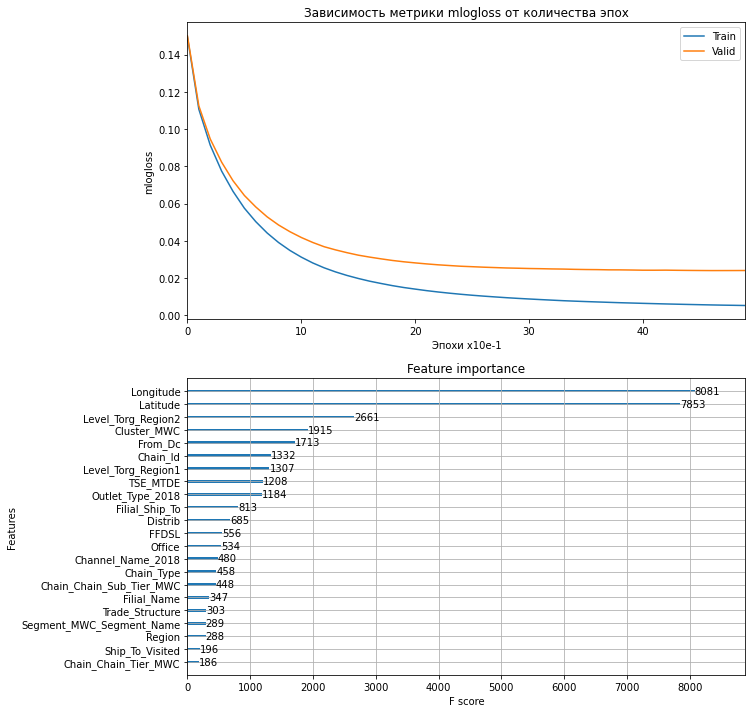

In [435]:
score_train = store['train']['mlogloss']
score_valid = store['valid']['mlogloss']

fig, axes = plt.subplots(2, 1, figsize=(10,12))
# Metrics
pd.DataFrame(data={'Train':score_train, 'Valid':score_valid}) \
    .plot(ax = axes[0], title='Зависимость метрики mlogloss от количества эпох')
axes[0].set_xticklabels((np.arange(epochs) * 10).astype(str))
axes[0].set_xlabel('Эпохи x10e-1')
axes[0].set_ylabel('mlogloss')
# Feature importance
xgb.plot_importance(bst, ax=axes[1])
plt.show()

Мы получили похожую точность модели. XGBoost на первое по важности поставил признаки: Longitude, Latitude

### Эксперимент. CatBoost

In [436]:
# from catboost import Pool, CatBoostClassifier

# train_data = [["summer", 1924, 44],
#               ["summer", 1932, 37],
#               ["winter", 1980, 37],
#               ["summer", 2012, 204]]

# eval_data = [["winter", 1996, 197],
#              ["winter", 1968, 37],
#              ["summer", 2002, 77],
#              ["summer", 1948, 59]]

# cat_features = [0]

# train_label = ["France", "USA", "USA", "UK"]
# eval_label = ["USA", "France", "USA", "UK"]


# train_dataset = Pool(data=train_data,
#                      label=train_label,
#                      cat_features=cat_features)

# eval_dataset = Pool(data=eval_data,
#                     label=eval_label,
#                     cat_features=cat_features)

# # Initialize CatBoostClassifier
# model = CatBoostClassifier(iterations=10,
#                            learning_rate=1,
#                            depth=2,
#                            loss_function='MultiClass')
# # Fit model
# model.fit(train_dataset)
# # Get predicted classes
# preds_class = model.predict(eval_dataset)
# # Get predicted probabilities for each class
# preds_proba = model.predict_proba(eval_dataset)
# # Get predicted RawFormulaVal
# preds_raw = model.predict(eval_dataset, 
#                           prediction_type='RawFormulaVal')

### Stacking

### hyperopt

### Эксперимент. Подбор параметров модели с помощью GridSearchCV

Воспользуемся GridSearchCV, чтобы найти лучшие параметры для модели.

In [49]:
# Получим полный набор данных X, y без пропущенных значений
X, y, _, _, _, _ = get_data(list_of_features=feature_importance_list[:18])
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
model = get_model(X, y, rfc, do_val=False)

parameters = {
    'classifier__n_estimators'            : [10, 100],
    'classifier__max_depth'               : [None, 30],
    'classifier__min_samples_split'       : [2, 4],
    'classifier__random_state'            : [42],
}

grid_search = GridSearchCV(model, parameters, n_jobs=-1, verbose=10)

print("Начало поиска лучших параметров...")
print("pipeline:", [name for name, _ in model.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(X, y)
print("Выполнено за %0.3f сек." % (time() - t0))
print()

print("Лучший score: %0.3f" % grid_search.best_score_)
print("Лучший набор параметров:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Размер выборки train: 129308, valid: 55419
Начало поиска лучших параметров...
pipeline: ['preprocess', 'classifier']
parameters:
{'classifier__max_depth': [None, 30],
 'classifier__min_samples_split': [2, 4],
 'classifier__n_estimators': [10, 100],
 'classifier__random_state': [42]}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:  5.4min remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  35 out of  40 | elapsed:  5.5min remaining:   46.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.1min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  6.1min finished


Выполнено за 409.425 сек.

Лучший score: 0.983
Лучший набор параметров:
	classifier__max_depth: None
	classifier__min_samples_split: 2
	classifier__n_estimators: 100
	classifier__random_state: 42


### Эксперимент. Оценка точности модели в кросс-валидации

Настал момент оценить насколько хорошо данная модель будет работать на практике. Для этого используем технику перекрестной проверки.

In [50]:
# Получим полный набор данных X, y без пропущенных значений
X, y, _, _, _, _ = get_data(list_of_features=feature_importance_list[:18])
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model = get_model(X, y, rfc, do_val=False)
scores = cross_val_score(model, X, y, cv=3)
print('Средняя оценка при кросс-валидации: %.3f' % (scores.mean()))

Размер выборки train: 129308, valid: 55419
Средняя оценка при кросс-валидации: 0.981


Как и ожидалось, при кросс-валидации средний скор получился немного меньше.

## Выводы

В процессе выполнения работы входные данные были проанализированы и очищены. Для ответа на некоторые вопросы, привлекался человек из бизнеса со знанием предметной области. Разработан алгоритм восстановления координат точек по координатам соседних точек. Обнаружены скрытые пропущенные значения в иерархиях дистрибьюторов и сотрудников. Проанализирован целевой признак. Выполнен анализ пропущенных значений.

Выбрана метрика для оценки и классификатор. Полученный набор данных является несбалансированным, поэтому для оценки модели была использована метрика balanced accuracy score, которая учитывает несбалансированность классов. В процессе моделирования было достигнуто значение метрики больше 0.98, при этом одинаково хорошая оценка достигалась при использовании разных классификаторов, например, Logistic Regression. Было решено остановиться на алгоритме  Random Forest Classifier, который показал максимальное значение.

Анализ важности признаков показал, что вклад признаков, которые относятся к иерархиям дистрибьюторов и сотрудников, выше, чем координат торговых точек. При этом не подтверждено существенное влияние отсутствия иерархий  на правильность ответа. С другой стороны мы убедились, что малое значение (до 40) записей в классе, приводит к низкой точности предсказания. Из-за этого последовала рекомендация предупреждать пользователя о наличии таких классов, но не предстказывать их.

Тогда было решено удалить строки с пропущенными значениями, что позволило улучшить точность модели. Дальнейших эксперименты проводились с данными без пропущенных значений.

Были проведен эксперименты для выявления зависимости точности модели от количества признаков. Обнаружилось, что можно отбросить несколько признаков с минимальной важностью, без влияния на точность модели.

Финально был выполнен подбор параметров модели с помощью Grid Search, а также путем техники перекрестной проверки оценена способность модели работать на практике.